### Modules

In [1]:
import pandas as pd
import logging
from youtube_search import YoutubeSearch
from pytubefix import YouTube, version
from pydub import AudioSegment

import os
import re
import datetime
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

os.makedirs('datasets/songs', exist_ok=True)
os.makedirs('datasets/wav_songs', exist_ok=True)

### Variables
```yaml
This module contains the configuration for the youtube search and download
You can change the configuration here

YOUTUBE_BASE_URL: The base url for the youtube search
YOUTUBE_SEARCH_MAX_RESULTS: The maximum number of results to return from the youtube search
YOUTUBE_CLIENT_TYPE: The type of client to use for the youtube search
YOUTUBE_MAX_VIDEO_LENGTH: The maximum length of a video in seconds
YOUTUBE_MIN_VIDEO_LENGTH: The minimum length of a video in seconds

SONG_SIZE_PER_TITLE: size (count) songs per title
SEGMENT_LENGTH: The length of each segment in seconds

LAGU_DAERAH_PATH: The path to the lagu daerah dataset
DOWNLOADED_SONGS_PATH: The path to the downloaded songs
SONGS_WAV_PATH: The path to the songs in wav format
```

In [2]:

YOUTUBE_BASE_URL = 'https://www.youtube.com/watch?v='
YOUTUBE_SEARCH_MAX_RESULTS = 150
YOUTUBE_CLIENT_TYPE='IOS'
YOUTUBE_MAX_VIDEO_LENGTH = 450
YOUTUBE_MIN_VIDEO_LENGTH = 30

SONG_SIZE_PER_TITLE=100
SEGMENT_LENGTH = 30

# LAGU_DAERAH_PATH = 'data/lagu_daerah.csv'
# LAGU_DAERAH_PATH = 'data/lagu_daerah_alternatif.csv'
LAGU_DAERAH_PATH = 'data/lagu_daerah_5.csv'
DOWNLOADED_SONGS_PATH = 'data/downloaded_songs.csv'
SONGS_WAV_PATH = 'data/songs_wav.csv'

### Load Scrapping Result

In [3]:
data = pd.read_csv(LAGU_DAERAH_PATH, sep=',')
data.head()

,nama_lagu,asal,keyword
0,Kicir-kicir,Jakarta,kicir kicir
1,Ampar-ampar Pisang,Kalimantan Selatan,ampar ampar pisang
2,Yamko Rambe Yamko,Papua,yamko rambe yamko
3,Apuse,Papua Barat,apuse
4,Bengawan Solo,Jawa Tengah,bengawan solo


### Search and Download Music Function

In [4]:
import requests

API_BASE_URL = 'http://192.168.1.6:3000'

def search_yt(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        results = YoutubeSearch(query, max_results).to_dict()
        for result in results:
            result['url'] = YOUTUBE_BASE_URL + result['id']
        return results
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []

def search_yt_alternate(query, max_results=YOUTUBE_SEARCH_MAX_RESULTS):
    try:
        res = requests.get(f'{API_BASE_URL}/search-selenium?query={query}&max_results={max_results}')
        
        json = res.json()
        
        return json['videos']
    except Exception as e:
        logging.error(f"Error searching YouTube for query '{query}': {e}")
        return []
    
def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def dl_video(url):
    try:
        yt = YouTube(url, YOUTUBE_CLIENT_TYPE)
        logging.info(f'Downloading {yt.title}...')
        
        normalized_title = normalized_yt_title(yt.title)
        
        # check if video already downloaded
        filepath= f'datasets/songs/{normalized_title}.mp3'
        if os.path.exists(filepath):
            logging.info(f'File already exists: {filepath}')
            
            return filepath
        
        audio_stream = yt.streams.get_audio_only()
        
        audio_stream.download(output_path='datasets/songs', filename=normalized_title, mp3=True)
        
        return f'datasets/songs/{normalized_title}.mp3'
    except Exception as e:
        logging.error(f"Error downloading video from URL '{url}': {e}")
        return None
    
def parse_duration(duration_str):
    duration_str = duration_str.replace('.', ':')
    if duration_str.count(':') == 2:
        duration = datetime.datetime.strptime(duration_str, '%H:%M:%S')
    else:
        duration = datetime.datetime.strptime(duration_str, '%M:%S')
        
    return duration.hour * 3600 + duration.minute * 60 + duration.second

In [5]:
dl_results = []

for index, row in data.iterrows():
    # Construct the search keyword
    keyword = f"Lagu Daerah {row['nama_lagu']}"
    # searched_songs = search_yt(keyword)
    searched_songs = search_yt_alternate(keyword)
    
    logging.info(f"Found {len(searched_songs)} results for '{keyword}'")
    if len(searched_songs) < SONG_SIZE_PER_TITLE:
        logging.info(f"Not enough results for '{keyword}', skipping...")
        continue
    
    downloaded_count = 0
    for song in searched_songs:
        if downloaded_count >= SONG_SIZE_PER_TITLE:
            logging.info(f"Downloaded {downloaded_count} songs for '{keyword}'")
            break
        
        # jika judul yt tidak ada match sama sekali dengan kata kata yang dicari, skip
        if not any(word.lower() in song['title'].lower() for word in row['keyword'].lower().split()):
            logging.info(f"Skipping '{song['title']}' as it doesn't match the search keyword")
            continue
        
        try:
            duration = parse_duration(song['duration'])
            if duration < YOUTUBE_MAX_VIDEO_LENGTH and duration > YOUTUBE_MIN_VIDEO_LENGTH:                    
                path = dl_video(song['url'])
                if (path == None):
                    continue
                
                # Append the result to downloaded_results list
                dl_results.append({
                    'title': song['title'],
                    'nama_lagu': row['nama_lagu'],
                    'region': row['asal'],
                    'keyword': keyword,
                    'duration': duration,
                    'url': song['url'],
                    'path': path
                })
                logging.info(f"Downloaded: {song['title']} from {song['url']}")
                
                downloaded_count += 1
            else:
                logging.warning(f"Duration of {song['title']} is too long: {duration} seconds")
        except Exception as e:
            logging.error(f"Error processing song {song['title']}: {e}")

2025-01-07 18:34:25,500 - INFO - Found 150 results for 'Lagu Daerah Kicir-kicir'
2025-01-07 18:34:25,702 - INFO - Downloading KICIR KICIR | Lagu Daerah DKI Jakarta - Betawi | Budaya Indonesia | Dongeng Kita...
2025-01-07 18:34:28,551 - INFO - Downloaded: KICIR KICIR | Lagu Daerah DKI Jakarta - Betawi | Budaya Indonesia | Dongeng Kita from https://www.youtube.com/watch?v=lhZf7qGZzsE
2025-01-07 18:34:28,774 - INFO - Downloading KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak...
2025-01-07 18:34:31,252 - INFO - Downloaded: KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak from https://www.youtube.com/watch?v=0wTJULU2REc
2025-01-07 18:34:31,469 - INFO - Downloading Kicir Kicir Jakarta...
2025-01-07 18:34:33,548 - INFO - Downloaded: Kicir Kicir Jakarta from https://www.youtube.com/watch?v=jMynoFKskhc
2025-01-07 18:34:33,727 - INFO - Downloading Kicir Kicir (Lagu Daerah Betawi)...
2025-01-07 18:34:36,313 - INFO - Downloaded: Kicir Kicir (Lagu Daerah Betawi) from https://www.youtube.com/wat

In [6]:
# get total
logging.info(f"Total downloaded songs: {len(dl_results)}")

2025-01-07 18:48:56,221 - INFO - Total downloaded songs: 500


### Save list of songs to csv

In [7]:
df = pd.DataFrame(dl_results)

df.to_csv('data/downloaded_songs.csv', index=False)

### Convert to wav format

In [8]:
def convert_to_wav(path):
    if path is None:
        logging.error('File path is None')
        return None
    
    try:
        wav_path = path.replace('songs', 'wav_songs').replace('.mp3', '.wav')
        
        if os.path.exists(wav_path):
            logging.info(f'File already exists: {wav_path}')
            return wav_path
        
        logging.info(f'Converting {path} to {wav_path}')
        
        audio = AudioSegment.from_file(path)
        audio.export(wav_path, format='wav')
        
        return wav_path
    except Exception as e:
        logging.error(f'Exception occurred: {e}')
        return None

In [9]:
df['wav_path'] = df['path'].apply(convert_to_wav)

2025-01-07 18:48:56,269 - INFO - Converting datasets/songs/kicir_kicir_lagu_daerah_dki_jakarta_betawi_budaya_indonesia_dongeng_kita.mp3 to datasets/wav_songs/kicir_kicir_lagu_daerah_dki_jakarta_betawi_budaya_indonesia_dongeng_kita.wav
2025-01-07 18:48:57,693 - INFO - Converting datasets/songs/kicir_kicir_lagu_dan_tari_nusantara_lagu_anak.mp3 to datasets/wav_songs/kicir_kicir_lagu_dan_tari_nusantara_lagu_anak.wav
2025-01-07 18:48:58,588 - INFO - Converting datasets/songs/kicir_kicir_jakarta.mp3 to datasets/wav_songs/kicir_kicir_jakarta.wav
2025-01-07 18:48:59,473 - INFO - Converting datasets/songs/kicir_kicir_lagu_daerah_betawi.mp3 to datasets/wav_songs/kicir_kicir_lagu_daerah_betawi.wav
2025-01-07 18:49:00,400 - INFO - Converting datasets/songs/heidydianalydianataliariaangelina_medley_kicirkicirwarungpojoktaribali_1987_anekaria_safari.mp3 to datasets/wav_songs/heidydianalydianataliariaangelina_medley_kicirkicirwarungpojoktaribali_1987_anekaria_safari.wav
2025-01-07 18:49:01,802 - INFO 

In [10]:
df = df[df['wav_path'].notnull()]

In [11]:
df

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,KICIR KICIR | Lagu Daerah DKI Jakarta - Betawi...,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,267,https://www.youtube.com/watch?v=lhZf7qGZzsE,datasets/songs/kicir_kicir_lagu_daerah_dki_jak...,datasets/wav_songs/kicir_kicir_lagu_daerah_dki...
1,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,234,https://www.youtube.com/watch?v=0wTJULU2REc,datasets/songs/kicir_kicir_lagu_dan_tari_nusan...,datasets/wav_songs/kicir_kicir_lagu_dan_tari_n...
2,Kicir Kicir Jakarta,Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,232,https://www.youtube.com/watch?v=jMynoFKskhc,datasets/songs/kicir_kicir_jakarta.mp3,datasets/wav_songs/kicir_kicir_jakarta.wav
3,Kicir Kicir (Lagu Daerah Betawi),Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,237,https://www.youtube.com/watch?v=CcFbCjM2jsM,datasets/songs/kicir_kicir_lagu_daerah_betawi.mp3,datasets/wav_songs/kicir_kicir_lagu_daerah_bet...
4,"HeidyDiana,LydiaNatalia,RiaAngelina - Medley K...",Kicir-kicir,Jakarta,Lagu Daerah Kicir-kicir,375,https://www.youtube.com/watch?v=F64ixtfvgqo,datasets/songs/heidydianalydianataliariaangeli...,datasets/wav_songs/heidydianalydianataliariaan...
...,...,...,...,...,...,...,...,...
495,"BENGAWAN SOLO ,Gesang KERONCONG Karaoke",Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,307,https://www.youtube.com/watch?v=LXhNj3Yp7zo,datasets/songs/bengawan_solo_gesang_keroncong_...,datasets/wav_songs/bengawan_solo_gesang_keronc...
496,Bengawan Solo,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,274,https://www.youtube.com/watch?v=RokdibqBiqs,datasets/songs/bengawan_solo.mp3,datasets/wav_songs/bengawan_solo.wav
497,Bengawan Solo - Classical guitar cover by Grac...,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,158,https://www.youtube.com/watch?v=sDFp0fXoIKU,datasets/songs/bengawan_solo_classical_guitar_...,datasets/wav_songs/bengawan_solo_classical_gui...
498,Bengawan Solo - Chan Yung Yung,Bengawan Solo,Jawa Tengah,Lagu Daerah Bengawan Solo,236,https://www.youtube.com/watch?v=0H_1goAVTQc,datasets/songs/bengawan_solo_chan_yung_yung.mp3,datasets/wav_songs/bengawan_solo_chan_yung_yun...


In [12]:
df.to_csv('data/songs_wav.csv', index=False)

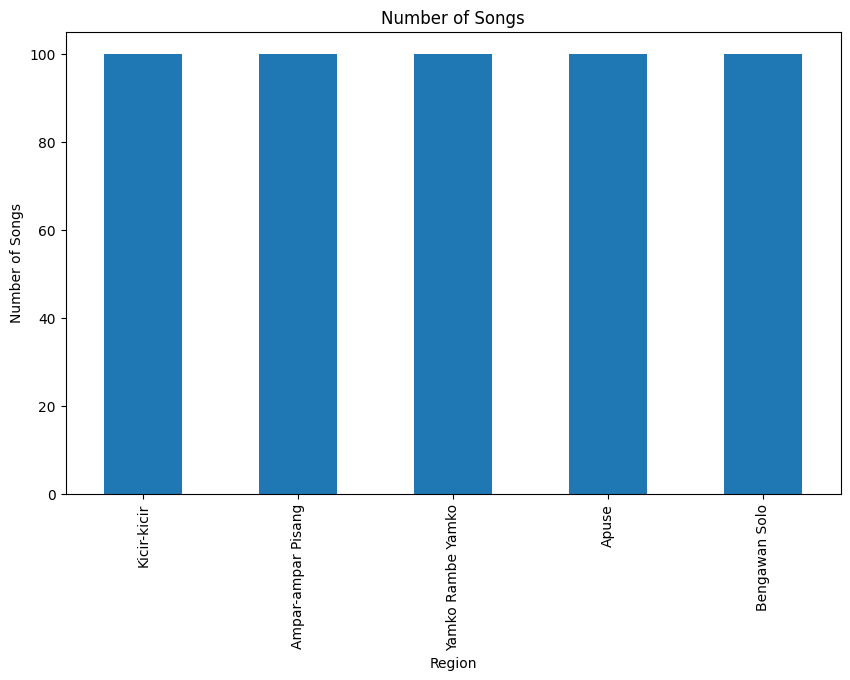

In [13]:
import matplotlib.pyplot as plt

# Count the number of songs per region
region_counts = df['nama_lagu'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
# show number in bar
region_counts.plot(kind='bar')
plt.title('Number of Songs')
plt.xlabel('Region')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.show()